<a href="https://colab.research.google.com/github/tomkeane07/rugby_tracker/blob/segment-objects/RugbyFieldRegistration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [208]:
# !pip install  opencv-python==3.4.2.17
# !pip install  opencv-contrib-python==3.4.2.17
%matplotlib inline

In [209]:
try:
  model
except:
  ! git clone https://github.com/ultralytics/yolov5  # clone
  ! pip install -r ./yolov5/requirements.txt  # install
  import torch
  model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

In [210]:
from google.colab import drive
from google.colab.patches import cv2_imshow
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import imutils
import cv2
import numpy as np
import copy
import sys
from sklearn.cluster import AgglomerativeClustering
try:
  from pyfld import FastLineDetector
except:
  ! pip install pyfld
  from pyfld import FastLineDetector
import collections
import pandas as pd
from moviepy.editor import *
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from os import linesep
from scipy.spatial import distance
from itertools import chain
import matplotlib
import matplotlib.pyplot as plt
import operator
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [211]:
import numpy as np
import sys

In [212]:
class ImgMorphOperator:
  def __init__(self):
    # self.kernel2 = np.ones((2,2), np.uint8)
    self.kernel3 = np.ones((3,3), np.uint8)
    # self.kernel4 = np.ones((4,4), np.uint8)
    # self.kernel5 = np.ones((5,5), np.uint8)
    # self.kernel6 = np.ones((6,6), np.uint8)
    self.kernel8 = np.ones((8,8), np.uint8)
    # self.kernel8x1 = np.ones((8,1), np.uint8)
    self.kernel10 = np.ones((10,10), np.uint8)
    self.kernel15 = np.ones((15,15), np.uint8)
    # self.kernel20 = np.ones((20,20), np.uint8)
    self.kernel30 = np.ones((30,30), np.uint8)
    self.kernel50 = np.ones((50,50), np.uint8)
    # self.kernel1x100 = np.ones((1,100), np.uint8)
    # self.kernel1x200 = np.ones((1,200), np.uint8)
    # self.kernel1x500 = np.ones((1,500), np.uint8)
    self.kernel5x50 = np.ones((5,50), np.uint8)
    self.kernel2x15 = np.ones((2,15), np.uint8)
    self.kernel15x1 = np.ones((15,1), np.uint8)
    self.kernel15x2 = np.ones((15,2), np.uint8)
    self.kernel5x30 = np.ones((5,30), np.uint8)
    self.kernel1x15 = np.ones((1,15), np.uint8)
    self.kernel1x30 = np.ones((1,30), np.uint8)
    self.kernel60x1 = np.ones((60,1), np.uint8)
    self.kernel75 = np.ones((75, 75), np.uint8)
    self.kernel1x85 = np.ones((1, 85), np.uint8)
    # self.kernel85 = np.ones((85, 85), np.uint8)
    # self.kernel100 = np.ones((100,100), np.uint8)


  def run(self, mask):
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, self.kernel8)
    # mask = cv2.dilate(mask, self.kernel30, 1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, self.kernel75)
    mask = cv2.dilate(mask, self.kernel15x1, 1)
    mask = cv2.dilate(mask, self.kernel15x1, 1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, self.kernel75)
    mask = cv2.erode(mask, self.kernel5x30, 1)
    mask = cv2.erode(mask, self.kernel5x30, 1)
    mask = cv2.erode(mask, self.kernel5x30, 1)
    mask = cv2.erode(mask, self.kernel5x30, 1)
    mask = cv2.erode(mask, self.kernel5x30, 1)
    mask = cv2.dilate(mask, self.kernel15x1, 1)
    mask = cv2.dilate(mask, self.kernel8, 1)
    # mask = cv2.erode(mask, self.kernel1x30, 1)
    # mask = cv2.erode(mask, self.kernel1x30, 1)
    # mask = cv2.erode(mask, self.kernel1x30, 1)
    # mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, self.kernel30)
    return mask

  def run1(self, mask):
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, self.kernel8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, self.kernel15)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, self.kernel15)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, self.kernel1x30)
    mask = cv2.dilate(mask, self.kernel5x30, 1)
    mask = cv2.dilate(mask, self.kernel8, 1)
    return mask

In [213]:
class Point(list):
    def __init__(self, x, y):
        super().__init__([x,y])
    @property
    def x(self):
        return self[0]
    @property
    def y(self):
        return self[1]

In [214]:
class Segment(list):
    def __init__(self, x1, y1, x2, y2):
        super().__init__([x1, y1, x2, y2])
        self._type = "other"
        self._angle = None
        self._slope=None
        self._length = None
        self._y_length = None
        self._x_length = None
        self._p1 = None
        self._p2 = None
        self._cartesian = None

    @property
    def type(self):
        return self._type

    @type.setter
    def type(self, value):
        if not isinstance(value, str):
            raise ValueError("Type must be a string")
        self._type = value

    @property
    def x1(self):
        return self[0]

    @property
    def y1(self):
        return self[1]

    @property
    def x2(self):
        return self[2]

    @property
    def y2(self):
        return self[3]

    @property
    def angle(self):
        if self._angle is None:
            self._angle = np.arctan2(self.y2 - self.y1, self.x2 - self.x1)
            self._slope = np.tan(self.angle)
        return self._angle

    @property
    def slope(self):
        if self._slope is None:
          if self.angle is not None:
            self._slope = np.tan(self.angle)
          else:
            rise=self.y2 - self.y1
            run = self.x2 - self.x1
            if run == 0:
              run=10**-100
            self._slope = rise/run
        if self._slope == 0:
          self._slope = 10**-100
        return self._slope

    @property
    def length(self):
        if self._length is None:
            self._length = np.sqrt((self.x2 - self.x1) ** 2 + (self.y2 - self.y1) ** 2)
        return self._length

    @property
    def y_length(self):
        if self._y_length is None:
            self._y_length = abs(self.y2 - self.y1)
        return self._y_length

    @property
    def x_length(self):
        if self._x_length is None:
            self._x_length = abs(self.x2 - self.x1)
        return self._x_length

    @property
    def p1(self):
        if self._p1 is None:
            self._p1 = Point(self.x1, self.y1)
        return self._p1

    @property
    def p2(self):
        if self._p2 is None:
            self._p2 = Point(self.x2, self.y2)
        return self._p2

    @property
    def cartesian(self):
        if self._cartesian is None:
            self._cartesian = [self.slope, self.y1 - self.slope * self.x1]
        return self._cartesian

    def swap_x(self):
        self[0], self[2] = self[2], self[0]

    def swap_y(self):
        self[1], self[3] = self[3], self[1]

In [215]:
class FastLineDetector:
    def __init__(self, length_threshold=10, distance_threshold=1.414213562,
                canny_th1=50.0, canny_th2=50.0, canny_aperture_size=3, do_merge=False,
                xlen_threshold=0, ylen_threshold=0):
        """
        Parameters
        ----------
        length_threshold : int or float, default 10
            Segment shorter than this will be discarded.
        distance_threshold : int or float, default 1.41421356
            A point placed from a hypothesis line segment farther than this will be regarded as an outlier.
        canny_th1 : int or float, default 50
            First threshold for hysteresis procedure in cv2.canny().
        canny_th2 : int or float, default 50
            Second threshold for hysteresis procedure in cv2.canny().
        canny_aperture_size : int, default 3
            Aperturesize for the sobel operator in cv2.canny().
            If zero, Canny() is not applied and the input image is taken as an edge image.
        do_merge : bool, default False
            If true, incremental merging of segments will be perfomred.
        xlen_threshold : int or float, default 0
            Segment shorter than this along x-axis will be discarded.
        ylen_threshold : int or float, default 0
            Segment shorter than this along y-axis will be discarded.
        """
        if (length_threshold < 0):
            raise ValueError("length_threshold must not be negative.")
        if (distance_threshold < 0):
            raise ValueError("distance_threshold must not be negative.")
        if (canny_th1 < 0):
            raise ValueError("canny_th1 must not be negative.")
        if (canny_th2 < 0):
            raise ValueError("canny_th2 must not be negative.")
        if (xlen_threshold < 0):
            raise ValueError("xlen_threshold must not be negative.")
        if (ylen_threshold < 0):
            raise ValueError("ylen_threshold must not be negative.")

        self.length_threshold = length_threshold
        self.distance_threshold = distance_threshold
        self.canny_th1 = canny_th1
        self.canny_th2 = canny_th2
        self.canny_aperture_size = canny_aperture_size
        self.do_merge = do_merge
        self.xlen_threshold = xlen_threshold
        self.ylen_threshold = ylen_threshold

    def detect(self, image):
        """
        Detect lines in the input image.

        Parameters
        ----------
        image : numpy ndarray
            A grayscale input image (dtype=np.uint8).

        Reterns
        -------
        lines : numpy ndarray
            A vector of specifying the beginning and ending point of a line.
            Where vector is (x1, y1, x2, y2), point 1 is the start, point 2 is the end.
            Returned lines are directed so that the brighter side is placed on left.
        points : numpy ndarray
            Pixels used in line detection.
        """
        image = np.array(image)
        segments, points = self.line_detection(image)
        if segments == []:
            raise LineNotFound("The image has no line segments")
        return np.array(np.array(segments), dtype="object").T, np.array(points,dtype="object")

    def line_detection(self, src):
        self._h, self._w = src.shape
        if self.canny_aperture_size == 0:
            canny = src
        else:
            canny = cv2.Canny(image=src, threshold1=self.canny_th1, threshold2=self.canny_th2, apertureSize=self.canny_aperture_size)

        canny[:5, :5] = 0
        canny[self._h-5:, self._w-5:] = 0

        points_all = []
        segments_all = []
        if np.all(canny == 0):
            return segments_all, points_all

        for r in range(self._h):
            for c in range(self._w):
                if canny[r,c] == 0:
                    continue
                pt = Point(c,r)
                points, canny = self.get_chained_points(canny, pt)

                if len(points) - 1 < self.length_threshold:
                    points = []
                    continue

                segments = self.extract_segments(points, xmin=0, xmax=self._w-1, ymin=0, ymax=self._h-1)

                if len(segments) == 0:
                    points = []
                    continue

                for seg in segments:
                    if (seg.length < self.length_threshold) or (seg.x_length < self.xlen_threshold) or (seg.y_length < self.ylen_threshold):
                        continue
                    if (seg.x1 <= 4 and seg.x2 <= 4) or (seg.y1 <= 4 and seg.y2 <= 4) or (seg.x1 >= self._w-5 and seg.x2 >= self._w-5) or (seg.y1 >= self._h-5 and seg.y2 >= self._h-5):
                        continue
                    segments_all.append(seg)
                    points_all.append(np.array(points))
                points = []
                segments = []

        if self.do_merge is False:
            return segments_all, points_all

        ith = len(segments_all) - 1
        jth = ith - 1
        while (ith >= 1 or jth >= 0):
            seg1 = segments_all[ith]
            seg2 = segments_all[jth]
            seg_merged = self.merge_segments(seg1, seg2)
            if seg_merged is None:
                jth -= 1
            else:
                segments_all[jth] = seg_merged
                del segments_all[ith]
                ith -= 1
                jth = ith - 1
            if jth < 0:
                ith -= 1
                jth = ith - 1
        return segments_all, points_all

    def get_point_chain(self, img):
        """
        Parameters
        ----------
        img : numpy ndarray
            Input edge image.

        Reterns
        -------
        point_chain : list
            Extracted point chain.
        """
        point_chain = []
        if np.all(img == 0):
            raise PointChainNotFound("The image has no point chain")

        # rs, cs = np.where(img != 0)
        # for r, c in zip(rs, cs):
        for r in range(img.shape[0]):
            for c in range(img.shape[1]):
                # Skip for non-seeds
                if img[r,c] == 0:
                    continue
                # Found seeds
                pt = Point(c,r)
                # Get point chain
                points, img = self.get_chained_points(img, pt)
                point_chain.append(points)
        return point_chain

    def get_chained_points(self, img, pt):
        """
        Parameters
        ----------
        img : numpy ndarray
            Input edge image.
        pt : Point
            Start point to search chained points.

        Reterns
        -------
        points : list of Point
            Extracted chained points.
        img : numpy ndarray
            Points removed image.
        """
        if img[pt.y, pt.x] == 0:
            raise ValueError("img[pt.y, pt.x] must not be 0")
        points = [pt]
        img[pt.y, pt.x] = 0

        direction = 0.0
        step = 0
        getting = True
        while(getting):
            pt, direction = self.get_chained_point(img, pt, direction, step)
            if pt is None:
                getting = False
                break
            points.append(pt)
            step += 1
            img[pt.y, pt.x] = 0
        return points, img

    def get_chained_point(self, img, pt, direction, step):
        """
        Find the neighboring edge point.
        Edge points closer to the direction are given priority.
        However, when step=0, it does not depend on the direction.
        Returns (None, None) if no edge point is found.

        Parameters
        ----------
        img : numpy ndarray
            Input edge image.
        pt : Point
            Start point to search the neighboring edge point.
        direction : int or float
            Previous search direction.
        step : int
            Current number of searches.

        Reterns
        -------
        point : Point
            Extracted neighbor chained point.
        direction : int or float
            Recalculated direction.
        """
        def direction_fixer(dir):
            if dir <= 180:
                return dir
            return dir - 360
        indices = {0:(1,1), 45:(1,0), 90:(1,-1), 135:(0,-1),
                   180:(-1,-1), 225:(-1,0), 270:(-1,1), 315:(0,1)} # Clockwise from lower right

        min_dir_diff = 315.0
        for i in (0, 45, 90, 135, 180, 225, 270, 315):
            ci = pt.x + indices[i][1]
            ri = pt.y + indices[i][0]
            if ri < 0 or ri == img.shape[0] or ci < 0 or ci == img.shape[1]:
                continue
            if img[ri, ci] == 0:
                continue
            if step == 0:
                chained_pt = Point(ci, ri)
                direction = direction_fixer(i)
                return chained_pt, direction
            if step > 0:
                curr_dir = direction_fixer(i)
                dir_diff = abs(curr_dir - direction)
                dir_diff = abs(direction_fixer(dir_diff))
                if dir_diff <= min_dir_diff:
                    min_dir_diff = dir_diff
                    consistent_pt = Point(ci, ri)
                    consistent_direction = direction_fixer(i)

        if min_dir_diff < 90.0:
            chained_pt = consistent_pt
            direction = (direction * step + consistent_direction) / (step + 1)
            return chained_pt, direction
        return None, None

    def extract_segments(self, points, xmin=0, xmax=None, ymin=0, ymax=None):
        """
        Extract segments from point chain.

        Parameters
        ----------
        points : list of Point
            Point chain for extraction.
        xmin : int or float, default 0
            Minimum x. Segment's x smaller than xmin are rounded to xmin.
        xmax : int or float, optional
            Minimum x. Segment's x larger than xmax are rounded to xmax.
        ymin : int or float, default 0
            Minimum y. Segment's y smaller than ymin are rounded to ymin.
        ymin : int or float, optional
            Minimum y. Segment's y smaller than ymax are rounded to ymax.
        """
        segments = []
        total = len(points)
        skip = 0
        for i in range(total-self.length_threshold):
            if skip > 0:
                skip -= 1
                continue

            ps = points[i]
            pe = points[i+self.length_threshold]

            is_line = True
            l_points = [ps]

            for j in range(1, self.length_threshold):
                pt = Point(points[i+j].x, points[i+j].y)
                dist = self.dist_point_line(ps, pe, pt)
                if dist > self.distance_threshold:
                    is_line = False
                    break
                l_points.append(pt)

            # Line check fail, test next point
            if is_line is False:
                continue

            l_points.append(pe)

            vx, vy, x, y = cv2.fitLine(np.array(l_points).astype(np.float32), cv2.DIST_L2, 0, 0.01, 0.01)
            a = Point(x.item(), y.item())
            b = Point(x.item() + vx.item(), y.item() + vy.item())
            ps = self.get_incident_point(a, b, ps, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

            # Extending line
            for j in range(self.length_threshold+1, total-i):
                pt = Point(points[i+j].x, points[i+j].y)
                dist = self.dist_point_line(a, b, pt)
                if dist > self.distance_threshold:
                    vx, vy, x, y = cv2.fitLine(np.array(l_points).astype(np.float32), cv2.DIST_L2, 0, 0.01, 0.01)
                    a = Point(x.item(), y.item())
                    b = Point(x.item() + vx.item(), y.item() + vy.item())
                    dist2nd = self.dist_point_line(a, b, pt)
                    if dist2nd > self.distance_threshold:
                        j -= 1
                        break
                pe = pt
                l_points.append(pt)
            vx, vy, x, y = cv2.fitLine(np.array(l_points).astype(np.float32), cv2.DIST_L2, 0, 0.01, 0.01)
            a = Point(x.item(), y.item())
            b = Point(x.item() + vx.item(), y.item() + vy.item())
            e1 = self.get_incident_point(a, b, ps, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
            e2 = self.get_incident_point(a, b, pe, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
            segments.append(Segment(e1.x, e1.y, e2.x, e2.y))
            if self.length_threshold == 1:
                j = 1
            skip = j
        return segments

    @staticmethod
    def dist_point_line(p1, p2, p3):
        """
        Calcurate the distance between the line (p1 to p2) and point (p3).
        """
        u = np.array([p2.x - p1.x, p2.y - p1.y])
        v = np.array([p3.x - p1.x, p3.y - p1.y])
        l = abs(np.cross(u, v)/ np.linalg.norm(u))
        return l

    @staticmethod
    def get_incident_point(p1, p2, p3, xmin=0, xmax=None, ymin=0, ymax=None):
        """
        Calcurate the incident point on the line (p1 to p2) from point (p3).
        """
        l = np.cross([p1.x, p1.y, 1.0], [p2.x, p2.y, 1.0])
        lh = [l[0], l[1], 0.0]
        xk = [p3.x, p3.y, 1.0]

        lk = np.cross(xk, lh)
        xk = np.cross(lk, l)

        xk = xk/xk[2]

        if xk[0] < xmin:
            pt_x = xmin
        elif xmax is not None and xk[0] > xmax:
            pt_x = xmax
        else:
            pt_x = xk[0]

        if xk[1] < ymin:
            pt_y = ymin
        elif ymax is not None and xk[1] > ymax:
            pt_y = ymax
        else:
            pt_y = xk[1]

        return Point(pt_x, pt_y)

    def adjust_left_of_segment_to_be_higher(self, src, seg, gap=1, num_points=10):
        """
        Adjust the left side of the segment to be higher value.
        The line segment is divided into num_points and evaluated by the average
        of the values at vertically separated positions by a gap.

        Parameters
        ----------
        src : numpy ndarray
            Source image
        seg : Segment
            Segment to adjust.
        gap : int or float, default 1
            Distance from the segment when getting the value.
        num_points : int, default 10
            Divide the line segment into num_points and get the value.

        Reterns
        -------
        seg : Segment
            Adjusted segment.
        """
        if seg.x1 == 0 and seg.x2 == 0 and seg.y1 == 0 and seg.y2 == 0:
            return seg
        start = seg.p1
        end = seg.p2

        dx = end.x - start.x
        dy = end.y - start.y

        x10 = np.linspace(seg.x1, seg.x2, num_points)
        y10 = np.linspace(seg.y1, seg.y2, num_points)

        x10L = np.round(x10 + gap * np.cos(seg.angle + np.pi/2)).astype(int)
        y10L = np.round(y10 + gap * np.sin(seg.angle + np.pi/2)).astype(int)
        x10L_inboard = np.logical_and(x10L >= 0, x10L < src.shape[1])
        y10L_inboard = np.logical_and(y10L >= 0, y10L < src.shape[0])
        x10L = x10L[x10L_inboard * y10L_inboard]
        y10L = y10L[x10L_inboard * y10L_inboard]
        left = src[y10L, x10L].mean()

        x10R = np.round(x10 - gap * np.cos(seg.angle + np.pi/2)).astype(int)
        y10R = np.round(y10 - gap * np.sin(seg.angle + np.pi/2)).astype(int)
        x10R_inboard = np.logical_and(x10R >= 0, x10R < src.shape[1])
        y10R_inboard = np.logical_and(y10R >= 0, y10R < src.shape[0])
        x10R = x10R[x10R_inboard * y10R_inboard]
        y10R = y10R[x10R_inboard * y10R_inboard]
        right = src[y10R, x10R].mean()

        if right > left:
            seg.swap_x()
            seg.swap_y()

        return seg

    def merge_segments(self, seg1, seg2):
        """
        Merge segments if some conditions are passed.

        Parameters
        ----------
        seg1 : Segment
            Segment 1.
        seg2 : Segment
            Segment 2.

        Reterns
        -------
        seg_merged : Segment
            Merged segment.
        """
        p1 = Point(seg1.x1, seg1.y1)
        p2 = Point(seg1.x2, seg1.y2)

        seg1mid = Point((seg1.x1 + seg1.x2)/2, (seg1.y1 + seg1.y2)/2)
        seg2mid = Point((seg2.x1 + seg2.x2)/2, (seg2.y1 + seg2.y2)/2)

        seg1len = np.sqrt((seg1.x1 - seg1.x2)**2 + (seg1.y1 - seg1.y2)**2)
        seg2len = np.sqrt((seg2.x1 - seg2.x2)**2 + (seg2.y1 - seg2.y2)**2)

        mid_dist = np.sqrt((seg1mid.x - seg2mid.x)**2 + (seg1mid.y - seg2mid.y)**2)
        ang_diff = abs(seg1.angle - seg2.angle)

        dist = self.dist_point_line(p1, p2, seg2mid)

        if dist <= self.distance_threshold * 2 and mid_dist <= seg1len/2 + seg2len/2 + 20 and\
           ang_diff <= np.deg2rad(5.0):
           seg_merged = self.merge_lines(seg1, seg2)
           return seg_merged
        else:
            return None

    @staticmethod
    def merge_lines(seg1, seg2):
        """
        Merge line segments.

        Parameters
        ----------
        seg1 : Segment
            Segment 1.
        seg2 : Segment
            Segment 2.

        Reterns
        -------
        seg_merged : Segment
            Merged segment.
        """
        ax = seg1.x1
        ay = seg1.y1
        bx = seg1.x2
        by = seg1.y2

        cx = seg2.x1
        cy = seg2.y1
        dx = seg2.x2
        dy = seg2.y2

        dlix = bx - ax
        dliy = by - ay
        dljx = dx - cx
        dljy = dy - cy

        li = np.sqrt(dlix**2 + dliy**2)
        lj = np.sqrt(dljx**2 + dljy**2)

        xg = (li * (ax + bx) + lj * (cx + dx)) / (2 * (li + lj))
        yg = (li * (ay + by) + lj * (cy + dy)) / (2 * (li + lj))

        if dlix == 0:
            thi = np.pi/2
        else:
            thi = np.arctan(dliy / dlix)

        if dljx == 0:
            thj = np.pi/2
        else:
            thj = np.arctan(dljy / dljx)

        if np.abs(thi - thj) <= np.pi / 2:
            thr = (li * thi + lj * thj) / (li + lj)
        else:
            tmp = thj - np.pi * (thj / abs(thj))
            thr = li * thi + lj * tmp
            thr /= (li + lj)

        axg = (ay - yg) * np.sin(thr) + (ax - xg) * np.cos(thr)
        bxg = (by - yg) * np.sin(thr) + (bx - xg) * np.cos(thr)
        cxg = (cy - yg) * np.sin(thr) + (cx - xg) * np.cos(thr)
        dxg = (dy - yg) * np.sin(thr) + (dx - xg) * np.cos(thr)

        delta1xg = min([axg, bxg, cxg, dxg])
        delta2xg = max([axg, bxg, cxg, dxg])

        delta1x = delta1xg * np.cos(thr) + xg
        delta1y = delta1xg * np.sin(thr) + yg
        delta2x = delta2xg * np.cos(thr) + xg
        delta2y = delta2xg * np.sin(thr) + yg

        seg_merged = Segment(delta1x, delta1y, delta2x, delta2y)
        return seg_merged

In [216]:
class PitchIsolator:
  def __init__(self, imgMorphOperator=None):
    self.imo = ImgMorphOperator() if imgMorphOperator==None else imgMorphOperator
  # (70,115,85), (80,255,180)

  def findPitch(self, image, range=[(0, 95, 55), (115, 255, 170)], run='0'):
    mask = cv2.inRange(image, lowerb=range[0], upperb=range[1])
    yg = cv2.bitwise_not(cv2.inRange(image, lowerb=(65,145,125), upperb=(92,175,155)))
    dg = cv2.bitwise_not(cv2.inRange(image, lowerb=(65,93,56), upperb=(77,115,100)))
    # yg = cv2.bitwise_not(cv2.inRange(image, lowerb=(55,135,115), upperb=(100,185,165)))
    # dg = cv2.bitwise_not(cv2.inRange(image, lowerb=(55,83,46), upperb=(77,115,100)))
    mask = cv2.bitwise_and(mask, yg)
    mask = cv2.bitwise_and(mask, dg)
    if run=='0':
      # cv2_imshow(dg)
      # cv2_imshow(mask)
      mask = self.imo.run(mask)
      mask = self.cropImg(mask)
    elif run=='1':
      mask = self.imo.run1(mask)
    return mask

  def removeNonPitch(self, image, mask):
    # apply mask
    return cv2.bitwise_and(image, image, mask=mask)

  def isoLines(self, image, range=[(110,150,150), (130,255,255)]):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lowerb=range[0], upperb=range[1])
    return cv2.bitwise_and(image, image, mask=mask)


  def cropImg(self, image,tol=1):
      # img is 2D image data
      # tol  is tolerance
      self.cropMask = image>tol
      return image[np.ix_(self.cropMask.any(1),self.cropMask.any(0))]


  def blockBillboards(self, image):
    red=          cv2.bitwise_not(cv2.inRange(image, (85, 46, 150), (120, 135, 180)))
    pink      =         cv2.bitwise_not(cv2.inRange(image, (200, 60, 150), (255, 140, 245)))
    navy        =          cv2.bitwise_not(cv2.inRange(image, (250, 40, 5), (255, 135, 52)))
    cream     =          cv2.bitwise_not(cv2.inRange(image, (30, 90, 120), (100, 150, 255)))
    guinBlack   =    cv2.bitwise_not(cv2.inRange(image, (0, 0, 0), (255, 120, 100)))
    bbyblue    =      cv2.bitwise_not(cv2.inRange(image, (250, 165, 25), (255, 255, 155)))
    yellow    =      cv2.bitwise_not(cv2.inRange(image, (15, 240, 240), (60, 255, 255)))
    yellowGrass =     cv2.bitwise_not(cv2.inRange(image, (115,215,190), (150,255,225)))
    mask = red & pink & navy & cream & guinBlack & bbyblue & yellow & yellowGrass
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, self.imo.kernel8)
    # cv2_imshow(mask)
    image= cv2.bitwise_and(image,  image, mask=mask)
    # cv2_imshow(image)
    return image


  def lineImgPrep(self, image):
    image = cv2.convertScaleAbs(image, alpha=1.25, beta=15)
    blackenBlack = cv2.inRange(image, (0,0,0), (20,20,20))
    # image = cv2.bitwise_and(image,  image, mask=blackenBlack)
    mwrongs = cv2.bitwise_not(cv2.inRange(image, (130, 145, 125), (170, 210, 190)))
    mwrongs = cv2.bitwise_not(cv2.add(cv2.bitwise_not(mwrongs), blackenBlack))
    # mwrongs=cv2.morphologyEx(mwrongs, cv2.MORPH_OPEN, self.imo.kernel15)
    # mwrongs=cv2.morphologyEx(mwrongs, cv2.MORPH_CLOSE, self.imo.kernel8)
    mwrongs=cv2.morphologyEx(mwrongs, cv2.MORPH_CLOSE, self.imo.kernel1x30)
    # sys.exit(0)
    image = cv2.bitwise_and(image,  image, mask=mwrongs)
    image=self.blockBillboards(image)
    # # lineMask = cv2.inRange(image, (110, 175, 135), (205, 250, 205))
    # # lineMask=cv2.cv2.erode(lineMask, self.imo.kernel8, 1)
    # lineMask = cv2.inRange(image, (110, 175, 135), (195, 250, 195))
    # lineMask=cv2.morphologyEx(lineMask, cv2.MORPH_CLOSE, self.imo.kernel8)
    # lineMask=cv2.dilate(lineMask, self.imo.kernel3)
    # image = cv2.bitwise_and(image,  image, mask=lineMask)
    # sys.exit()
    return image


  def isolatePitch(self, image):
    mask = self.findPitch(cv2.convertScaleAbs(copy.deepcopy(image), alpha=1.5, beta=-30))
    playersFrame = self.removeNonPitch(image[np.ix_(self.cropMask.any(1),self.cropMask.any(0))], mask)
    mask = self.findPitch(cv2.convertScaleAbs(playersFrame, alpha=1.5, beta=-30), run='1')
    shi=np.shape(image)
    linesFrame = self.removeNonPitch(image[np.ix_(self.cropMask.any(1),self.cropMask.any(0))], mask)
    linesFrame = self.lineImgPrep(linesFrame)
    # print(np.shape(linesFrame))
    linesFrame = cv2.resize(linesFrame, (2560,800))
    playersFrame = cv2.resize(playersFrame, (2560,800))
    return playersFrame, linesFrame

In [217]:
class LineCornerOperations:
  def collinear(self, ln1, ln2, atol=1e-1):
    a = np.abs(ln1.x1 * (ln1.y2 - ln2.y1) + ln1.x2 * (ln2.y1 - ln1.y1) + ln2.x1 * (ln1.y1 - ln1.y2))
    b = np.abs(ln2.x2 * (ln1.y2 - ln2.y1) + ln1.x2 * (ln2.y1 - ln2.y2) + ln2.x1 * (ln2.y2 - ln1.y2))
    return  np.isclose(a, 0,  atol=atol) and np.isclose(b, 0, atol=atol)

  def parallel(self, ln1, ln2):
    return (((self.getSlope(ln1) - self.getSlope(ln2))**2)**0.5 <= 10**-10)

  def joinColLines(self, ln1, ln2):
    xs = np.sort(np.append(ln1, ln2)[::2])
    ys = np.sort(np.append(ln1,ln2)[1::2])
    return [xs[0], ys[0], xs[-1], ys[-1]]

  def getCollinears(self, line, lines):
      colLines = []
      for li in lines:
        ln =  li
        if self.collinear(line, ln):
          colLines.append(ln)
      return colLines

  def points(self, ln):
      return (ln.x1, ln.y1),(ln.x2, ln.y2)

  def handleMainLines(self, lines):
    collines = []
    for ln in lines:
      collines.append(self.getColLines(ln, lines))
    # print(collines)

  def indicesOfUpPitchLine(self, lines, of=""):
    ids = np.array([row[1] for row in lines])
    if of=="":
      return np.where((ids == 'UpPitchLine') | (ids == 'nearSideLine'))[0]
    else:
      return np.where((ids == of))[0]

  def refine_lines(self, lines, minLenFactor=0.05):
    keepLines0, keepLines1, colLineCheckLines, colLineNumArr = [], [], [], []
    longestLen = np.max([ln.length for ln in lines])
    shortestLen = np.min([ln.length for ln in lines])
    defaultDist = longestLen*minLenFactor
    for li in lines:
        ln =  li
        dist = ln.length
        if dist > defaultDist:
          keepLines0.append(ln)
    return lines

  def lineIntersection(self, ln1, ln2):
    line1 = np.reshape(ln1, (2,-1))
    line2 = np.reshape(ln2, (2,-1))
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])
    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]
    div = det(xdiff, ydiff)
    if div == 0:
      raise Exception('lines do not intersect')
    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return [x, y]

  def findCrossPoints(self, lines):
    crossPoints = [[],[]]
    lns = np.asarray(lines)
    nsl = lns[np.where((lns[:,1]=="nearSideLine"))[0]][0]
    fsl = lns[np.where((lns[:,1]=="farSideLine"))[0]][0]
    cross = lns[np.where((  np.invert(lns[:,1]=="nearSideLine")) & ( np.invert(lns[:,1]=="farSideLine")))[0]]
    byLength = np.argsort([-self.dist(ln=ln) for ln in cross[:,0]])
    cross=cross[byLength][0:2]
    crossLineNames = {"tryLineL":0,"22L":1,"halfway":2,"22R":3,"tryLineR":4}
    if crossLineNames[cross[0][1]] > crossLineNames[cross[1][1]]:
      cross=np.flip(cross, axis=0)
    for ln in cross:
      crossPoints[0].append(self.lineIntersection(ln[0], nsl[0]) )
      crossPoints[0].append(self.lineIntersection(ln[0], fsl[0]) )
      crossPoints[1].append(ln.type)
      if len(crossPoints[0]) >=4:
        break
    return crossPoints

  def deleteIndexes(self, lines, delIndexs):
    for index in sorted(delIndexs, reverse=True):
      if isinstance(index, int) and index < len(lines):
        del lines[index]
    return lines

lco = LineCornerOperations()

In [218]:
class LineMerger:
  def __init__(self):
    self.cornerPoints = np.empty(shape=(0,3))

  def lengthPriority(self, lineGroup):
      repeated_lines = []
      # Calculate repeated lines
      for ln in lineGroup:
          repetitions = int(ln.length) // 10
          repeated_lines.extend([ln] * repetitions)
      # Combine original lineGroup with repeated lines
      return lineGroup + repeated_lines

  def getCornerPoints(self, lines):
    self.CornerPoints = {'ovrMax': 100, 'ovrMin': 100}
    types, indices = np.unique([ln.type for ln in lines], return_index=True)
    ys = np.array([lines[i].y1 for i in indices] + [lines[i].y2 for i in indices])
    minIndex = np.argmin(ys)
    maxIndex = np.argmax(ys)
    for lnType, index in zip(types, indices):
      line = lines[index]
      minPoint = [getattr(line, 'x2' if minIndex % 2 else 'x1'), getattr(line, 'y2' if minIndex % 2 else 'y1')]
      maxPoint = [getattr(line, 'x2' if maxIndex % 2 else 'x1'), getattr(line, 'y2' if maxIndex % 2 else 'y1')]
      if ys[minIndex] < self.CornerPoints['ovrMin']:
        self.CornerPoints['ovrMin'] = ys[minIndex]
      if ys[minIndex] > self.CornerPoints['ovrMax']:
        self.CornerPoints['ovrMax'] = ys[minIndex]
      self.CornerPoints[lnType] = {'minPoint': minPoint, 'maxPoint': maxPoint}

  def refineLines(self, lineGroup, minLenFactor=0.3):
    delLinesIndex = []
    longestLen  = np.max([lco.dist(lco.points(x)) for x in lineGroup[:,0]])
    shortestLen = np.min([lco.dist(lco.points(x)) for x in lineGroup[:,0]])
    defaultDist = longestLen*minLenFactor
    for i in range(len(lineGroup)):
        ln =  lineGroup[i][0]
        pt1,pt2 = lco.points(ln)
        dist = lco.dist((pt1,pt2))
        if dist < defaultDist:
          delLinesIndex.append(i)
          # keepLines1+=colLines
    return delLinesIndex

  def remove_outliers_bis(self, arr, k=1.4, lean=''):
    # print(arr)
    delIndex, mask=[], []
    arr = np.array(arr)
    mask = np.ones((arr.shape[0],), dtype=bool)
    if len(arr)<3: return arr,[]
    mu, sigma = np.mean(arr, axis=0), np.std(arr, axis=0, ddof=1)
    if lean=='up':
      mu[-1]-=np.abs(sigma[-1])*0.5
    elif  lean=='down':
      mu[-1]+=np.abs(sigma[-1])*0.5
    nCols=arr.shape[1]
    for j in range(nCols):
        col = arr[:, j]
        keep = np.abs((col[mask] - mu[j]) / sigma[j]) <= k
        mask[mask] &= keep
        # sys.exit(0)
        if len(arr[mask])<=1:
          mask = np.ones((arr.shape[0],), dtype=bool)
          if k > 5:
            print("quit")
            return arr, []
          return self.remove_outliers_bis(arr, k=k*1.5, lean=lean)
        for i in range(len(keep)):
          if not keep[i]:
            delIndex = np.append(delIndex, i)
    delIndex = np.unique(delIndex)
    return arr[mask], delIndex.astype(int)

  def mergeLineType(self, lineGroup, lnType):
    # print([ln.type for ln in lineGroup])
    # print("lineGroup", lineGroup)
    # delIndex = self.refineLines(lineGroup)
    # lineGroup = np.delete(lineGroup, delIndex, axis=0)
    eqs=self.lengthPriority(lineGroup)
    # print(eqs)
    # print([ln.type for ln in eqs])
    if lnType=="halfway":
      k=1.2
      lean=''
    elif lnType=="nearSideLine":
      k=1
      lean=''
    elif lnType=="farSideLine":
      k=1.2
      lean=''
    elif lnType=="tryLineL" or lnType=="tryLineR":
      k=1.2
      lean=''
    elif lnType=="22L" or lnType=="22R":
      k=1.2
      lean=''
    else:
      k=1.2
      lean=''
    # print(lnType)
    eqs, delIndexs = self.remove_outliers_bis(eqs,k=k, lean=lean)
    # if len(delIndex) > 0:
    i,j=0,0
    while  i <len(delIndexs)-1:
      j=delIndexs[i]
      if j >= len(lineGroup):break
      lineGroup = lco.deleteIndexes(lineGroup, delIndexs)
      i+=1
    minmaxX = [np.min(np.array([[ln.x1,ln.x2] for ln in lineGroup]).flatten()), np.max(np.array([[ln.x1,ln.x2] for ln in lineGroup]).flatten())]
    minmaxY = [np.min(np.array([[ln.y1,ln.y2] for ln in lineGroup]).flatten()), np.max(np.array([[ln.x1,ln.x2] for ln in lineGroup]).flatten())]
    newLine = Segment(minmaxX[0], np.poly1d(np.mean(eqs, axis=0))(minmaxX[0]),
                      minmaxX[1], np.poly1d(np.mean(eqs, axis=0))(minmaxX[1]))
    newLine.type=lnType
    return newLine

  def run(self, lines):
    # print(lines)
    delIndexs = [i for i, ln in enumerate(lines) if ln.type in ['other', 'UpPitchLine']]
    lines = lco.deleteIndexes(lines, delIndexs)
    # print(lines)
    self.getCornerPoints(lines)
    lnTypes = np.unique([ln.type for ln in lines])
    newLines = []
    for lnType in lnTypes:
      # print(lnType)
      self.indices = np.where([ln.type==lnType for ln in lines])[0]
      newLine = self.mergeLineType([lines[index] for index in self.indices], lnType)
      newLines.append(newLine)
    # print(newLines)
    return newLines

In [219]:
class LineClassifier:

  def lengthPrioritizeLines(self, lnTypes=[]):
    for lnT in lnTypes:
      lineGroup = [ln for ln in self.lines if ln.type == lnT]
      if len(lineGroup) == 0: continue
      # print("lnG", lineGroup)
      longLn = max(lineGroup, key=lambda ln: ln.length).length
      # print(shortLn)
      for i in range(len(self.lines)):
        ln=self.lines[i]
        if ln.type==lnT:
          factor = int((1.05*ln.length)/(longLn))*3
          for i in range(factor):
            self.lines.append(ln)


  @property
  def lineTypeSlopes(self):
    lineTypeSlopes =     {'UpPitchLine': [], 'halfway': [], 'other': [], '22L': [], 'tryLineL':[], 'tryLineR':[], '22R':[], 'nearSideLine':[], 'farSideLine':[]}
    for ln in self.lines:
      lnType=ln.type
      lineTypeSlopes[lnType].append(ln.slope)
    return lineTypeSlopes

  @property
  def lineTypeCs(self):
    lineTypeCs =     {'UpPitchLine': [], 'halfway': [], 'other': [], '22L': [], 'tryLineL':[], 'tryLineR':[], '22R':[], 'nearSideLine':[], 'farSideLine':[]}
    for ln in self.lines:
      lnType=ln.type
      lineTypeCs[lnType].append(ln.cartesian[1])
    return lineTypeCs

  @property
  def lineTypeYintercepts(self):
    lineTypeCs =     {'UpPitchLine': [], 'halfway': [], 'other': [], '22L': [], 'tryLineL':[], 'tryLineR':[], '22R':[], 'nearSideLine':[], 'farSideLine':[]}
    for ln in self.lines:
      lnType=ln.type
      C=ln.cartesian[1]
      slope=ln.slope
      lineTypeCs[lnType].append(-C/slope)
    return lineTypeCs

  @property
  def lineTypeLengthSum(self):
    lnsums = {'UpPitchLine': 0, 'halfway': 0, 'other': 0, '22L': 0, 'tryLineL':0, 'tryLineR':0, '22R':0, 'nearSideLine':0, 'farSideLine':0}
    for ln in self.lines:
      lnsums[ln.type] += ln.length
    return lnsums

  @property
  def lineTypeMeanPos(self):
    pos = {'UpPitchLine': [[0,0]], 'halfway': [[0,0]], 'other': [[0,0]], '22L': [[0,0]], 'tryLineL':[[0,0]], 'tryLineR':[[0,0]], '22R':[[0,0]], 'nearSideLine':[[0,0]], 'farSideLine':[[0,0]]}
    for ln in self.lines:
      lnType=ln.type
      pos[lnType].append(np.array([ln.x1+ln.x2, ln.y1+ln.y2])/2)
    for lnType in pos:
      if len(pos[lnType]) > 0:
        pos[lnType] = pos[lnType][1:]
      pos[lnType]=np.mean(pos[lnType], axis=0)
    return pos

  @property
  def lineTypeStdPos(self):
    pos = {'UpPitchLine': [[0,0]], 'halfway': [[0,0]], 'other': [[0,0]], '22L': [[0,0]], 'tryLineL':[[0,0]], 'tryLineR':[[0,0]], '22R':[[0,0]], 'nearSideLine':[[0,0]], 'farSideLine':[[0,0]]}
    for ln in self.lines:
      lnType=ln.type
      pos[lnType].append(np.array([ln.x1+ln.x2, ln.y1+ln.y2])/2)
    for lnType in pos:
      if len(pos[lnType]) > 0:
        pos[lnType] = pos[lnType][1:]
      pos[lnType]=np.std(pos[lnType], axis=0)
    return pos


  def removeBadCrossPitchLines(self):
    for ln in self.lines:
      lnT=ln.type
      slope=ln.slope
      if lnT=='tryLineL' or lnT=='22L' or lnT=='tryLineR' or lnT=='22R':
        if np.abs(np.mean(slope) - np.mean(self.lineTypeSlopes[lnT])) > 0.05:
          ln.type='other'
    self.lts = self.lineTypeSlopes
    for ln in self.lines:
      lnT=ln.type
      slope=ln.slope
      for typ in ['tryLineL','22L','tryLineR','22R']:
        if lnT=='other' and np.abs(ln.slope-np.mean(self.lts[typ]))<0.02:
          ln.type=typ

  def removeGoalPosts(self):
    mupos=self.lineTypeMeanPos
    self.stdpos=self.lineTypeStdPos
    for ln in self.lines:
      if ln.type=='halfway':
        if self.stdpos['halfway'][0]>200:
          ln.type='other'
        elif    self.lookingLeft and ln.x1 - mupos['22L'][0] < 0:
          ln.type='other'
        elif  self.lookingRight and  ln.x1 - mupos['22R'][0] > 0:
          ln.type='other'
    return self.lines


  def checkPerspective(self):
    self.lookingLeft=False
    self.lookingRight=False
    self.ltsums=self.lineTypeLengthSum
    if self.ltsums['22L'] > self.ltsums['22R']*15:
      self.lookingLeft=True
      self.lookingRight=False
    elif self.ltsums['22R'] > self.ltsums['22L']*15:
      self.lookingLeft=False
      self.lookingRight=True
    if self.lookingLeft or self.lookingRight:
      for ln in self.lines:
        if self.lookingLeft and (ln.type=='22R' or ln.type=='tryLineR'   ):
          ln.type='other'
        elif self.lookingRight and (ln.type=='22L' or ln.type=='tryLineL'):
          ln.type='other'
    self.muFSLSlope=np.mean(self.ltsums['farSideLine'])
    self.stdFSLSlope=np.std(self.ltsums['farSideLine'])

  def tryLineOrEndLine(self):
    delIndex=[]
    ptpYint=10000
    threshold=150
    i=0
    while ptpYint>threshold:
      i+=1
      if i%50==0:
        threshold+=15
      self.ltYint = self.lineTypeYintercepts
      LmdYint    = np.median(self.ltYint['tryLineL'])
      RmdYint    = np.median(self.ltYint['tryLineR'])
      LptpYint = np.ptp(self.ltYint['tryLineL']) if not self.ltYint['tryLineL']==[] else 10000
      RptpYint = np.ptp(self.ltYint['tryLineR']) if not self.ltYint['tryLineR']==[] else 10000
      for ln in self.lines:
        if ln.type=='tryLineL' or ln.type=='tryLineR':
          sign=ln.slope/np.abs(ln.slope)
          thisYint=-ln.cartesian[1]/ln.slope
          # thisSlope=ln.slope
          if ln.type=='tryLineL':
            mdYint = LmdYint
            ptpYint = LptpYint
          elif ln.type=='tryLineR':
            mdYint =  RmdYint
            ptpYint = RptpYint
          if ptpYint>150: break
          if (  sign*thisYint>sign*mdYint  ):
            # if len(np.where(self.lines[:,1]==ln.type)[0]) > 7:
              ln.type='other'
    return self.lines


  def twenty2orTryLine(self):
    delIndex=[]
    ptpYint=10000
    threshold=100
    i=0
    while ptpYint>threshold:
      i+=1
      if i%50==0:
        threshold+=15
      self.ltYint = self.lineTypeYintercepts
      LmdYint    = np.median(self.ltYint['22L'])
      RmdYint    = np.median(self.ltYint['22R'])
      # peak to peak
      LptpYint = np.ptp(self.ltYint['22L']) if not self.ltYint['22L']==[] else 10000
      RptpYint = np.ptp(self.ltYint['22R']) if not self.ltYint['22R']==[] else 10000
      for ln in self.lines:
        if ln.type=='22L' or ln.type=='22R':
          sign=ln.slope/np.abs(ln.slope)
          thisYint=-ln.cartesian[1]/ln.slope
          # thisSlope=ln.slope
          if ln.type=='22L':
            mdYint = LmdYint
            ptpYint = LptpYint
          elif ln.type=='22R':
            mdYint =  RmdYint
            ptpYint = RptpYint
          if ptpYint>threshold: break
          if (  sign*thisYint>sign*mdYint  ):
              ln.type='other'
    return self.lines

  def tryLn22OrSideLn(self):
    delIndex=[]
    self.meanPos=self.lineTypeMeanPos
    self.ltsum=self.lineTypeLengthSum
    for ln in self.lines:
      if ((ln.type=='tryLineL' or ln.type=='22L') and
          (self.ltsum['22L']+self.ltsum['tryLineL']<self.ltsum['22R']+self.ltsum['tryLineR']) and
          (self.meanPos[ln.type][0]>self.shi[1]*0.35 and self.meanPos[ln.type][1]>self.shi[0]*0.35)):
        if  self.isNearSideLine(ln.slope, ln.cartesian[1], ln):
          ln.type='nearSideLine'
        elif self.isFarSideLine(ln.slope, ln.cartesian[1], ln):
          ln.type='farSideLine'
        else:ln.type='UpPitchLine'
      elif ((ln.type=='tryLineR' or ln.type=='22R') and
            (self.ltsum['22L']+self.ltsum['tryLineL']>self.ltsum['22R']+self.ltsum['tryLineR'])and
            (self.meanPos[ln.type][0]<self.shi[1]*.65 and self.meanPos[ln.type][1]>self.shi[0]*0.35)):
        if  self.isNearSideLine(ln.slope, ln.cartesian[1], ln):
          ln.type='nearSideLine'
        elif self.isFarSideLine(ln.slope, ln.cartesian[1], ln):
          ln.type='farSideLine'
        else:ln.type='UpPitchLine'
    return self.lines

  def inNonTryLineQuad(self, ln):
    return ((ln.type=='tryLineL' and
                  (ln.x1>self.shi[1]*0.13 or ln.x2>self.shi[1]*0.13) and
                  (ln.y1>self.shi[0]*0 or ln.y2>self.shi[0]*0)) or
            (ln.type=='tryLineR' and
                          (ln.x1<self.shi[1]*0.87 or ln.x2<self.shi[1]*0.87) and
                          (ln.y1>self.shi[0]*0 or ln.y2>self.shi[0]*0))
            )

  def purgeFSLs(self):
    for ln in self.lines:
      if ln.type=='farSideLine':
        if self.lookingLeft or self.lookingRight:
          if self.lookingLeft:
            sl22 = np.mean(self.lts['22L'])
            sign=-sl22/(np.abs(sl22))
          elif self.lookingRight:
            sl22 = np.mean(self.lts['22R'])
            sign=-sl22/(np.abs(sl22))
          if (ln.slope-sign*0.02)*(sl22)>0:
            ln.type='UpPitchLine'

  def purgeNSLs(self):
    self.lts = self.lineTypeSlopes
    muslope=np.mean(self.lts['nearSideLine'])
    for ln in self.lines:
      if ln.type=='nearSideLine':
        if not (self.lookingLeft or self.lookingRight):
          if np.abs(muslope-ln.slope)>0.02:
            ln.type='UpPitchLine'
        if self.lookingLeft or self.lookingRight:
          if self.lookingLeft:
            sl22 = np.mean(self.lts['22L'])
            sign=-sl22/(np.abs(sl22))
          elif self.lookingRight:
            sl22 = np.mean(self.lts['22R'])
            sign=-sl22/(np.abs(sl22))
          if (ln.slope-sign*0.01)*(sl22)>0:
            ln.type='UpPitchLine'

  def is22R(self, slope, C, ln):
    return (True and   0.27 <= (slope   )  and  (slope   ) <= 0.8)

  def is22L(self, slope, C, ln):
    return self.is22R(-slope, C, ln)

  def isTrylR(self, slope, C, ln):
    return (True and   0.09 <= (slope   )  and  (slope   ) <= 0.4)

  def isTrylL(self, slope, C, ln):
    return self.isTrylR(-slope, C, ln)

  def isNearSideLine(self, slope, C, ln):
    return (np.isclose(slope, 0, atol=0.26, equal_nan=False) and
            (ln.y1>self.shi[0]*0.75 or ln.y2>self.shi[0]*0.75))

  def isFarSideLine(self, slope, C, ln):
    return (np.isclose(slope, 0, atol=0.11, equal_nan=False) and
            (ln.y1<self.shi[0]*0.15 or ln.y2<self.shi[0]*0.15))


  def classifyLine0(self, ln):
    slope = ln.slope
    C = ln.cartesian[1]
    # print("line")
    # print(slope, C, ln)
    if np.abs(slope) > 3: return "halfway"
    elif  self.is22L(slope,C,ln) :  return "22L"
    elif  self.is22R(slope,C,ln):  return "22R"
    elif  self.isTrylL(slope,C,ln):  return "tryLineL"
    elif  self.isTrylR(slope,C,ln):  return "tryLineR"
    elif  self.isFarSideLine(slope, C, ln) :      return "farSideLine"
    elif  self.isNearSideLine(slope,C, ln) :      return "nearSideLine"
    elif  np.isclose(slope, 0, atol=1.9e-1, equal_nan=False): return "UpPitchLine"
    else:
      return "other"

  def getPerspective(self, lines):
    # print("hlf std",np.std(self.lineTypeSlopes['halfway']))
    self.nearHalfway=np.isclose(np.mean(self.lineTypeSlopes['nearSideLine']), 0, 0.05)

  def makeFarSideLine(self):
    x=-1000000
    if True:# len(np.where(self.lines[:,1]=='farSideLine')[0])<10:
      mask = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
      mask = cv2.inRange(mask, lowerb=-1, upperb=0)
      xl,yl,xr,yr=-1,-1,-1,-1
      if self.lookingLeft:
        for y in range(self.shi[0]):
          for x in range(self.shi[1])[::-1]:
            if mask[y][x]==0:
              xl=x
              yl=y+25
              break
          if xl==x:
            break
        for y in range(self.shi[0]):
            if mask[y][self.shi[1]-2]==0:
              xr=self.shi[1]-1
              yr=y+25
              break
      elif self.lookingRight:
        for y in range(self.shi[0]):
            if mask[y][0]==0:
              xl=0
              yl=y+25
              break
        for y in range(self.shi[0]):
          for x in range(self.shi[1]):
            if mask[y][x]==0:
              xr=x
              yr=y+25
              break
          if xr==x:
            break
      else:
        for y in range(self.shi[0]):
            if mask[y][0]==0:
              xl=0
              yl=y+20
              break
        for y in range(self.shi[0]):
            if mask[y][-1]==0:
              xr=self.shi[1]-1
              yr=y+20
              break
      pts=np.array([xl,yl,xr,yr])
      ln=[pts,'farSideLine']
      eq=ln.cartesian
      newLn=np.array([pts,'farSideLine', eq, lco.dist(ln=pts)])
      if self.isFarSideLine(newln.slope, newln.cartesian[1], newLn):
        self.lines=np.append(self.lines, [newLn], axis=0)

  def classifyLines(self, lines, image=np.zeros((800, 2560, 3))):
    self.lines=lines
    self.image=image
    self.shi=np.shape(image)
    for ln in lines:
      lnType=str(self.classifyLine0(ln))
      ln.type = lnType
    self.ltsum=self.lineTypeLengthSum
    self.lengthPrioritizeLines(['22L','22R'])
    print("twenty2orTryLine")
    self.lines=self.twenty2orTryLine()
    print("tryLn22OrSideLn")
    self.lines=self.tryLn22OrSideLn()
    print("tryLineOrEndLine")
    self.lines=self.tryLineOrEndLine()
    print("lengthPrioritizeLines(['trylineL','trylineR'])")
    self.lengthPrioritizeLines(['trylineL','trylineR'])
    self.checkPerspective()
    print("removeBadCrossPitchLines")
    self.removeBadCrossPitchLines()
    self.checkPerspective()
    self.removeGoalPosts()
    self.checkPerspective()
    self.purgeFSLs()
    # self.makeFarSideLine()
    self.lengthPrioritizeLines(['nearSideLine','farSideLine', 'halfway'])
    self.purgeNSLs()
    return self.lines

In [220]:
class RugbyFieldRegistration:
  def __init__(self):
    self.frameCount=-1
    self.pld = PlayerDetector()
    self.lcd = LineCornerDetector(self)
    self.pt = PitchTransformer()
    self.imo = ImgMorphOperator()
    self.pi = PitchIsolator(self.imo)

  def detectPitch(self, rawFrame):
          self.frameCount+=1
          frame = rawFrame
          playersFrame, linesFrame = self.pi.isolatePitch(frame)
          playerCoords, plrDetectImage = self.pld.getPlayerCoords(copy.deepcopy(playersFrame))
          # return frame
          frame, crossPoints = self.lcd.applyLineDetector(self, linesFrame, startImage=plrDetectImage)
          # return frame
          # self.myWriter.cv2Writer.write(copy.deepcopy(cv2.resize(frame, (1600,1100))))
          # self.myWriter.writeFrame(frame)
          # return frame
          try:
            frameTr, playerCoords = self.pt.transformPitch(frame, crossPoints, playerCoords)
            # self.lcd.refineTransform(frameTr, frameTr)
            # cv2_imshow(frameTr)
            # sys.exit(0)
          except Exception as e:
            print("Failed pitch Transformation\n\n", e)
            playerCoords=[]
          pitchProjection = self.pt.projectPlayerCoords(playerCoords)
          frame = self.pt.mergeImageAndProjection(frame, pitchProjection)
          return frame

  def skipFrame(self, i, skipFrameRate):
      return not int(i % skipFrameRate)==0

  def flick_through_frames(self, myWriter):
    self.myWriter = myWriter
    i=-1
    while True:
      # Capture frame-by-frame
      ret, rawFrame = self.myWriter.cap.read()
      if ret==True:
        i+=1
        if not i % int(self.myWriter.start_fps/self.myWriter.output_fps)==0:
          continue
        if len(self.myWriter.skipFrames)>0 and i in self.myWriter.skipFrames:
          # self.myWriter.cv2Writer.write(rawFrame)
          continue
        print(f"frame {i}")
        if i in self.myWriter.skipFrames:
          continue
        if self.myWriter.quitEarly and i > self.myWriter.start_fps:
          break
        frame = self.detectPitch(rawFrame)
        # frame = cv2.resize(frame, (self.myWriter.frame_width, self.myWriter.frame_height))
        # cv2_imshow(frame)
        self.myWriter.writeFrame(frame)
        # sys.exit(0)
        # break
      else:
        print("Stream disconnected")
        break

In [221]:
# lll = []
# lo = [[1162.0224230614258, 697.835312792493, 1278.9828107325848, 713.1314361381162], [1018.9018575358232, 679.5415776952811, 1158.9665288917195, 697.2645226175323], [1018.9047511222872, 676.5071236561947, 1278.9744074399391, 710.1975589877023], [402.00000104904683, 670.9999999999999, 401.99999895089985, 718.9999999999999], [438.0322560140025, 667.7502087255626, 401.97232781294235, 668.3578683275258], [643.0000010709102, 669.9999999999999, 642.9999989290546, 718.9999999999999], [529.0000076329131, 667.9830296190179, 643.00043434908, 668.034304564122], [698.0788539062511, 641.3569412257102, 1012.1636041635345, 678.6210435892577], [624.8133149537879, 633.1237428042588, 662.0368815377362, 637.7000034570107], [680.0680860061307, 636.5404288237971, 1012.0540427010062, 675.5399580935504], [577.9115622864491, 625.690010598528, 661.8955528080797, 634.9475412314633], [530.9966079163966, 623.2292224305514, 576.8880322671093, 627.2712370505242], [535.9921913740242, 621.1598040214318, 574.9752330537589, 625.2368135031162], [327.9398917197296, 600.5004755920521, 434.9602411026159, 612.358819995798], [320.98382943711675, 596.6475334345988, 465.9696296196363, 613.2649789875853], [258.86841013603674, 592.8389250103904, 293.14430488432964, 596.7282767529579], [121.01377676988227, 578.9391177919374, 169.99355249073827, 584.0616487359565], [526.1834951925741, 572.0020941125334, 530.544180763538, 618.0431719772774], [1020.024465437071, 571.0337453882964, 1015.7994053096098, 629.0582088191704], [1026.5879722675022, 564.9777120633158, 1020.3696309924572, 647.9527586933987], [0.0006802061495490371, 565.1681286356553, 172.07070126185468, 581.2432030285747], [194.73445149443504, 583.3726153510712, 238.0718679438941, 588.3777212565026], [1027.8774041859103, 562.7716643350889, 1105.9770221426452, 571.2126021908399], [940.0288285286267, 555.7938677675162, 1020.1443041413511, 564.702231358268], [941.966688430306, 553.419124576939, 1014.0012070933278, 560.9885126266124], [583.6539372394308, 522.420990731354, 563.2096561563787, 554.7646189326967], [579.1720803583653, 520.1011758763676, 559.0543017151101, 553.4291477186565], [1051.01030338463, 400.8838464409239, 1107.9833261328668, 405.2191233965452], [1034.7043808780872, 401.05979266799255, 1021.119490821917, 561.095030069512], [1039.7549005852165, 400.0038144362621, 1026.737212876502, 561.9788802017681], [1042.0089692103147, 397.99765988885304, 1083.9679456972578, 401.3957952237113], [984.0149143785183, 392.8156666232463, 1033.9766819079305, 397.2620156637703], [700.0215889107249, 369.7318241597842, 735.0361781875359, 372.5505972504313], [696.0528550527605, 371.36389700839385, 734.9608921765268, 374.4871821159817], [104.01537020465915, 322.7772374566797, 140.9773997006814, 325.32754932466145], [1045.0262438709667, 336.86019944934503, 1040.119819848281, 397.92928439906643], [1040.6801347616074, 331.98258352524005, 1036.47190343027, 383.03889585264], [136.30872943920693, 282.4707414633428, 88.38092002880494, 312.6058274578833], [127.24720573012922, 284.38905395319574, 71.54257535088229, 318.8763787719864], [744.7402849696987, 252.43163614996107, 724.8023787597724, 284.4988814077595], [739.9686582482148, 252.02366343552583, 721.3758730102434, 282.62073960871015], [196.2024838499871, 245.31595657175666, 140.89756616519344, 279.8358891696543], [187.36045558024486, 247.5792388178781, 146.59407267946122, 271.9920289405715], [151.97782446021006, 225.61067455780207, 194.048249239333, 228.22295143761647], [241.78067257474376, 216.63325565651564, 201.9752371945587, 241.96108255731187], [272.2449344822232, 197.3543478829257, 243.4832813148666, 216.2118974109099], [1002.0073379803455, 187.8451309833145, 1053.064710311667, 190.92844603128], [923.9434866828711, 184.2565642639352, 998.9881308975968, 187.29331140392793], [790.3142035363647, 177.7343708891392, 770.5153300367762, 208.3334400195375], [1054.4997071847115, 180.96221600768328, 1050.856686493934, 228.91313796296706], [323.04703931990326, 165.09645917290243, 283.38972143642945, 190.60586694250512], [799.0169519504117, 164.39401483811227, 760.9642305612763, 166.27723597746822], [56.99601270782874, 144.38986059089024, 103.99112569017937, 147.15104022481438], [921.4510568417662, 139.02852126957882, 918.063427860937, 182.92772627840782], [1106.0175651348316, 132.51103938721747, 1199.0412125467212, 135.8527664437237], [984.1118333512505, 122.9192507009544, 943.0839422950503, 126.87141501734779], [1023.02260092463, 127.14045642046571, 985.9917397591711, 126.43138880511334], [88.00227703650008, 119.10453692894576, 128.00003158489832, 119.09059166068171], [412.17029307225386, 105.26487535388809, 359.4681234854701, 138.7370633588442], [1062.1614443284752, 97.08204382443537, 1058.599179760611, 148.0418846839983], [1071.967595266955, 93.70924639076907, 1107.9859192680606, 95.315703621311], [79.95544464308564, 92.21269425668353, 30.913278894849448, 95.82149455039968], [474.4015194232288, 68.58652202309436, 359.55554782189876, 142.3076127643921], [359.0231697258109, 65.488442534113, 319.0472922209185, 67.14278152339163], [1071.0051523869695, 54.85959680802886, 1109.9893503982119, 56.290202986119006], [1072.0050706710786, 52.86785258165571, 1111.0243629346926, 54.36507439092807], [198.9931811598347, 53.189569298061066, 150.9833584813728, 51.4626477418962], [872.0216501517912, 45.64822317197664, 906.0772894840555, 47.74418203608844], [1239.9999105723953, 45.47177098998962, 1278.9857016034036, 46.52783926481652], [51.162423319244674, 44.46398975848785, 0.16791639844488532, 61.50255487387722], [1201.0055959587892, 40.697163471810896, 1278.9974437926073, 42.13833428753783], [1221.2355893718843, 147.94122184165266, 1232.783469605203, 191.7936851780039], [1204.0093001970117, 73.0337917355914, 1212.1093100384182, 119.15642207310512], [1068.3352603104524, 38.01698702769633, 1065.7704522392864, 73.05639541911484], [1071.7244445070273, 36.978753741276705, 1061.1873434004258, 148.9235065106419], [984.0203357129602, 34.648610250100795, 1024.0021731687475, 36.96244885909637], [526.5876481293059, 35.876737318042125, 481.2954721414016, 64.4680641891238], [953.9981751987624, 32.05975873918992, 1050.9993343203084, 35.02179973262513], [1230.9712762779116, 38.59968750294185, 1278.9996559787858, 40.0117015700397], [78.97205751929998, 32.97322216614165, 15.36033458769743, 54.08568588942123], [807.0109442972276, 28.689052140842126, 845.9978439577023, 30.0612571755633], [758.915607718515, 29.199695120268082, 826.0127619034124, 31.650627962459886], [753.0084164578129, 26.701119013645666, 792.0056523344556, 27.79927716209657], [87.19307307820365, 32.52375080079279, 51.56991305930068, 44.74651460541355], [1224.0, 22.0, 1264.0, 22.0], [732.901705782068, 23.029602633346016, 767.9633748721762, 25.516385332894043], [640.0228970566513, 21.52791631622117, 693.9929391858018, 24.145577452505282], [1088.0, 20.0, 1124.0, 20.0], [569.0211229548634, 18.571205266140517, 611.017733556706, 20.640009848181617], [242.01133824781724, 17.801996878320004, 288.0322224702528, 20.43728962348196], [569.0172064741458, 16.602681708400137, 695.0406942350793, 22.060320910455946], [1245.0412404485958, 17.153754701695696, 1176.991711538989, 18.61365436059446], [449.00727291295885, 22.69926613906443, 495.02872456334285, 23.812243610420484], [414.8012855872484, 19.156715104438195, 447.9541926889517, 24.295524766921922], [472.01470687330976, 14.026065680839169, 508.0576824608544, 15.876383642357423], [549.9782985535359, 15.47645306210749, 511.0075123822616, 13.822944140800754], [75.0770683517015, 13.233364156382057, 0.0, 36.93318076286854], [972.9698947866198, 16.642744667269934, 1031.995029201075, 18.189668126685927], [473.01837399505615, 12.026734506000027, 511.0480904639517, 14.1307894873826], [902.0070106193266, 10.780934168052445, 952.0197947177269, 12.381460309705759], [886.0678855736858, 12.02675969856048, 851.0136453282608, 13.359030951196221], [734.0031372460548, 8.208720735396723, 794.9854662501967, 10.403772643734705], [777.0142329845847, 7.526712137985612, 837.9932422902866, 7.95721114217218], [352.0022042526239, 5.949063104372998, 420.00468162359397, 8.891814862877576], [279.02491184311305, 3.694940413961257, 327.0398744734382, 7.496352603574369], [289.00998360560743, 2.8019240528350853, 350.0062341839557, 5.876313033548788], [562.9467086174901, 1.1714953137607516, 714.9777777836402, 7.531227889272044]]

# # Generate segments with wider spread along the x-axis
# for ln in lo:
#   lll.append(Segment(ln[0], ln[1], ln[2], ln[3]))

# lll = LineClassifier().classifyLines(lll)
# # print(lll)
# print("classifyLines\n")
# # for line in lll:
# #     print(line, line.type)
# lll = LineMerger().run(lll)

In [222]:
class LineDrawer:

  def colorSet(self):
    return {
        "tryLineL"      : (0,0,165),
        "22L"           : (0, 220, 165),
        "halfway"       : (90, 165, 255),
        "22R"           : (165, 0, 0),
        "tryLineR"      : (165, 165, 50),
        "UpPitchLine"   : (255,255,255),
        "nearSideLine"  : (50,200,220),
        "farSideLine"   : (200,220,50),
        "other"         : (90, 50, 90)
    }

  def drawLines(self, image, lines, color=(0, 0, 0), thickness=2, metrics=False, lineColors=False, cartesianize=False):
    image = np.copy(image)
    # print(lines)
    for ln in lines:
      text = f"{np.round(ln.slope,2)}" if metrics else ""
      color = self.colorSet()[ln.type] if lineColors else color
      colors = []
      pt1,pt2 = [int(coord) for coord in ln.p1], [int(coord) for coord in ln.p2]
      cv2.line(image,
                pt1=pt1,
                pt2=pt2,
                color=color,
                thickness=thickness)
      cv2.putText(img=image, text=text, org=(pt1[0]-5, pt1[1]-5),
                  fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.4, color=(0, 0, 255),thickness=1)
      if cartesianize:
        text=str(np.round(ln.cartesian,2))
        cv2.putText(img=image, text=text, org=(pt2[0]-100, pt2[1]),
                    fontFace=cv2.FONT_HERSHEY_TRIPLEX, fontScale=0.4, color=(0, 0, 255),thickness=1)
    return image

In [223]:
class LineCornerDetector:
  def __init__(self, pd):
    self.ld = LineDrawer()
    self.lcl = LineClassifier()
    self.lm = LineMerger()
    self.pd=pd


  def lineImagePreprocessing(self, image):
    image = cv2.convertScaleAbs(image, alpha=1.2)
    # cv2_imshow(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2_imshow(image)
    # image = cv2.convertScaleAbs(image)
    # cv2_imshow(image)
    return image

  def detectLines(self, image):
    grey = self.lineImagePreprocessing(image)
    lines = np.rot90(
        FastLineDetector(do_merge=False).detect(grey)[0], k=1)
    lines = [Segment(ln[0], ln[1], ln[2], ln[3]) for ln in lines]
    # print("detectLines\n", lines)
    lines = lco.refine_lines(lines)
    return lines


  def detectAndDrawLines(self, startImage, image, color1=(255,255,255), color2=(0,255,0)):
    lines=self.detectLines(image)
    image0 = self.ld.drawLines(startImage, lines, color=color1, thickness=4, metrics=True, lineColors=False, cartesianize=False)
    cv2_imshow(image0)
    # sys.exit(0)
    # # print(lines)
    lines = self.lcl.classifyLines(lines, image)
    image0 = self.ld.drawLines(startImage, lines, color=color1, thickness=4, metrics=False, lineColors=True, cartesianize=True)
    cv2_imshow(image0)
    mergedlines = self.lm.run(copy.deepcopy(lines))
    image0 = self.ld.drawLines(startImage, mergedlines, color=color1, thickness=4, metrics=False, lineColors=True, cartesianize=True)
    cv2_imshow(image0)
    try:
      crossPoints = lco.findCrossPoints(mergedlines)
    except:
      print('couldn\'t find grid')
      crossPoints = []
    return startImage, crossPoints

  def applyLineDetector(self, pitchDetector, image, show=True, startImage=None):
    # cv2_imshow(image)
    if startImage is None:
      startImage=np.copy(image)
    # cv2_imshow(image)
    # sys.exit(0)
    image, crossPoints = self.detectAndDrawLines(startImage, image, color1=(150,50,50), color2=(255,255,100))
    # cv2_imshow(image)
    return image, crossPoints

  def refineTransform(self, startImage, image, color1=(255,255,255), color2=(0,255,0)):
    startImage=copy.deepcopy(image)
    dims =np.shape(image)
    # sys.exit(0)
    grey = self.lineImagePreprocessing(image)
    cv2_imshow(grey)
    lines = np.rot90(
        FastLineDetector(do_merge=False, canny_aperture_size=7).detect(grey)[0], k=1)
    lines = lco.refine_lines(lines)
    image0 = self.ld.drawLines(startImage, lines, color=color1, thickness=4, metrics=True, lineColors=False, cartesianize=False)
    cv2_imshow(image0)

In [224]:
class PlayerDetector:
  def __init__(self):
    self.model = model

  def isolatePlayers(self, image):
    # hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = np.zeros(shape=np.shape(image)[0:2])
    Grassmask = cv2.inRange(image, (20, 115,85), (80, 255, 150))
    notGrassmask = cv2.bitwise_not(Grassmask)
    notGrassImg = cv2.bitwise_and(image,  image, mask=notGrassmask)
    return notGrassImg

  def drawRectangles(self, image, dfResults, show=False):
    for index, row in dfResults.iterrows():
      imgResult = cv2.rectangle(image, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (255, 0, 0), 2)
      imgResult = cv2.putText(image, row['name'],  (row['xmin'], row['ymin']), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    try:
      if show:
        cv2_imshow(imgResult)
    except:
      print("no players detected")
    return image

  def classifyPlayers(self, image, df):
    df['color'] = [(0,100,0) for r in df.iterrows()]
    # df[['Ireland', 'England', 'Bib', 'Ref']] = [[0,0,0,0] for r in df.iterrows()]
    for i, row in df.iterrows():
      x0,y0,x1,y1 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
      # print(image)
      # sys.exit(0)
      box = image[y0:y1,x0:x1]
      box = self.isolatePlayers(box)
      # cv2_imshow(box)
      bsh = np.shape(box)
      box = box[1*bsh[0]//6:3*bsh[0]//6, bsh[1]//3:int(2*bsh[1]//3)]
      boxPxls = cv2.countNonZero(cv2.cvtColor(box, cv2.COLOR_BGR2GRAY))
      # 111, 162, 52
      # 106, 160, 54

      # 17, 78, 11
      # 70, 189, 108 - jersey
      # cv2_imshow(box)
      jrsys = {
          'England' :[((250,250,250),  (255,255,255)),  4, (255,255,255)],
          'Ref'     :[((1,1,1),           (90,90,90)),4, (50,50,50)],
          'Bib'     :[((0,	247, 223), (135,255,255)), 5, (135,255,255)],
          'Ireland' :[((50, 90, 40),    (155,220,180)), 5, (1,99,55)]
      }
      pxlCounts=[]
      for j in jrsys:
        dst = cv2.inRange(box, jrsys[j][0][0], jrsys[j][0][1])
        jrsyPxls = cv2.countNonZero(dst)*jrsys[j][1]
        pxlCounts.append(jrsyPxls)
        # print(jrsyPxls)
      # print(jrsys)
      jr = max(range(len(pxlCounts)), key=pxlCounts.__getitem__)
      df.at[i,'name']=list(jrsys)[jr]
      df.at[i,'color']=list(jrsys.values())[jr][-1]
        # row[jrKey] = jrsyPxls
        # df['color']=jrsys[]
        # df.at[i,'name']  = 'Other'
        # df.at[i,'color']  = (20,20,180)
    # display(df)
    return df

  def runDetector(self, image):
    def fixY(y):
      return (y+i*sh[0]//ycut)
    def fixX(x):
      return (x+j*sh[1]//xcut)
    dfResults = pd.DataFrame()
    xcut,ycut=14,2
    sh = np.shape(image)
    for i in range(ycut):
      y0=(sh[0]*i)//ycut
      y1 = sh[0]*(i+1)//ycut
      for j in range(xcut):
        # print("x")
        x0 = (sh[1]*j)//xcut
        x1 = (sh[1]*(j+1))//xcut
        box = image[y0:y1,x0:x1]
        # cv2_imshow(box)
        results = self.model(box)
        df = results.pandas().xyxy[0]
        # print(df)
        # df = df.loc[(df['confidence']>0.26)]
        df = pd.concat([df, df.loc[(y1-df['ymax']<20) & (df['ymax'] - df['ymin'] < 80)], df.loc[(df['ymin']-y0<20) & (df['ymax'] - df['ymin'] < 80)]]).drop_duplicates(keep=False)
        df = pd.concat([df, df.loc[(x1-df['xmax']<10) & (df['xmax'] - df['xmin'] < 10)], df.loc[(df['xmax']-x0<10) & (df['xmax'] - df['xmin'] < 10)]]).drop_duplicates(keep=False)
        # print(df)
        if df.shape[0] > 0:
          df[['xmin','xmax']] = df[['xmin','xmax']].apply(fixX)
          df[['ymin','ymax']] = df[['ymin','ymax']].apply(fixY)
          dfResults = pd.concat([dfResults, df], ignore_index=True)
    # results = self.model(self.isolatePlayers(image))
    results = self.model(image)
    dfResults = pd.concat([dfResults, results.pandas().xyxy[0]], ignore_index=True).drop_duplicates(keep=False)
    dfResults = dfResults.loc[(dfResults['class']==0) & (dfResults['confidence']>0)]
    return dfResults

  def getPlayerCoords(self, image):
    # Inference
    image = cv2.convertScaleAbs(image, alpha=1.5, beta=-30)
    dfResults = self.runDetector(image)
    dfResults[['xmin', 'ymin', 'xmax','ymax']] = dfResults[['xmin', 'ymin', 'xmax','ymax']].astype(int)
    dfResults = self.classifyPlayers(image, dfResults)
    # display(dfResults)
    image = self.drawRectangles(copy.deepcopy(image), dfResults)
    dfResults['x'] = (dfResults[['xmin', 'xmax']].mean(axis=1))
    dfResults['y'] = (dfResults['ymax'])
    # sys.exit(0)
    return np.array([dfResults[['x', 'y', 'name','color']].to_numpy()]), image

In [225]:
class PitchTransformer:
  def __init__(self):

    self.pitchImgShape = (800,1100)

  def drawPitch(self):
    pitch = np.full((self.pitchImgShape[1],self.pitchImgShape[0],3), (119,221,119), dtype=np.uint8)
    color=(240,240,240)
    pitch = cv2.rectangle(pitch, (50,50), (750, 1050), color, 4)
    #50m
    pitch = cv2.line(pitch, pt1=(50,550), pt2=(750,550), color=color, thickness=3)
    pitch = cv2.line(pitch, pt1=(50,830), pt2=(750,830), color=color, thickness=2)
    pitch = cv2.line(pitch, pt1=(50,270), pt2=(750,270), color=color, thickness=2)
    # 10m, 5m across
    pitch = cv2.line(pitch, pt1=(50,450), pt2=(750,450),   color=(150,150,150), thickness=1)
    pitch = cv2.line(pitch, pt1=(50,650), pt2=(750,650),   color=(150,150,150), thickness=1)
    pitch = cv2.line(pitch, pt1=(50,100), pt2=(750,100),   color=(150,150,150), thickness=1)
    pitch = cv2.line(pitch, pt1=(50,1000), pt2=(750,1000), color=(150,150,150), thickness=1)
    # 5m Up, 15m up
    pitch = cv2.line(pitch, pt1=(100,50), pt2=(100,1050), color=(150,150,150), thickness=1)
    pitch = cv2.line(pitch, pt1=(700,50), pt2=(700,1050), color=(150,150,150), thickness=1)
    pitch = cv2.line(pitch, pt1=(200,50), pt2=(200,1050), color=(150,150,150), thickness=1)
    pitch = cv2.line(pitch, pt1=(600,50), pt2=(600,1050), color=(150,150,150), thickness=1)
    return pitch

  def makeImageCorners(self, lineTypes):
    pts = []
    w, l = 750, 1000
    if "tryLineL" in lineTypes:
      pts.append([50,l*0.05])
      pts.append([w,l*0.05])
    if "22L" in lineTypes:
      pts.append([50,l*0.27])
      pts.append([w,l*0.27])
    if "halfway" in lineTypes:
      pts.append([50,l*0.55])
      pts.append([w,l*0.55])
    if "22R" in lineTypes:
      pts.append([50,l*0.83])
      pts.append([w,l*0.83])
    if "tryLineR" in lineTypes:
      pts.append([50,l*1.05])
      pts.append([w,l*1.05])
    pts=np.asarray(pts)
    # print(pts)
    return np.float32(pts)

  def transformPitch(self, image, crossPoints, playerCoords):
    # cv2_imshow(image)
    shape = np.shape(image)
    pts1 = np.float32(crossPoints[0])
    pts2 = self.makeImageCorners(crossPoints[1])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    image = cv2.warpPerspective(image,M,self.pitchImgShape)
    playerPts = cv2.perspectiveTransform(np.array([playerCoords[0][:,:2]], dtype=np.float32),M)
    try:
      playerCoords[0][:,0], playerCoords[0][:,1] = playerPts[0][:,0], playerPts[0][:,1]
    except Exception as e:
       print( str(e))
       playerCoords=[]
    return image, playerCoords

  def projectPlayerCoords(self, playerCoords):
    pitch = self.drawPitch()
    try:
      for p in playerCoords[0]:
          pitch = cv2.circle(pitch, (int(p[0]),int(p[1])), radius=10, color=p[3], thickness=-1)
    except:
      print("no players for pitch projection")
    return cv2.resize(pitch, ((524,720)))

  def mergeImageAndProjection(self, image, pitchProjection):
    sh = np.shape(pitchProjection)
    shi = np.shape(image)
    image = cv2.resize(image, (1280,720))
    return np.concatenate((image, pitchProjection), axis=1)

In [226]:
class VideoWriter:
  def __init__(self):
      self.fourcc = cv2.VideoWriter_fourcc('M','P','4','V')
      # self.fourcc = cv2.VideoWriter_fourcc(*'MP4V')
      self.api=0

  def writeFrame(self, frame):
    self.cv2Writer.write(copy.deepcopy(cv2.resize(frame, (2560,1100))))

  def write_video(self):
    self.cv2Writer = cv2.VideoWriter(
        self.save_path,
        self.api,
        self.fourcc,
        self.output_fps,
       (2560,1100))
    self.vpc.flick_through_frames(self)
    self.cv2Writer.release()
    # cv2.destroyAllWindows()

  def run(self, cap, save_path, VideoProcessorClass, skipFrames=[], quitEarly=False, output_fps=None):
    """
    lnD - lineDetector
    imgPrp - image Preprocessing
    """
    self.vpc = VideoProcessorClass
    self.cap = cap
    self.save_path = save_path
    self.skipFrames=skipFrames
    self.num_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    self.frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    self.frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    self.start_fps = int(cap.get(cv2.CAP_PROP_FPS))
    self.output_fps = self.start_fps if output_fps is None else output_fps
    self.quitEarly = quitEarly
    self.write_video()

frame 0


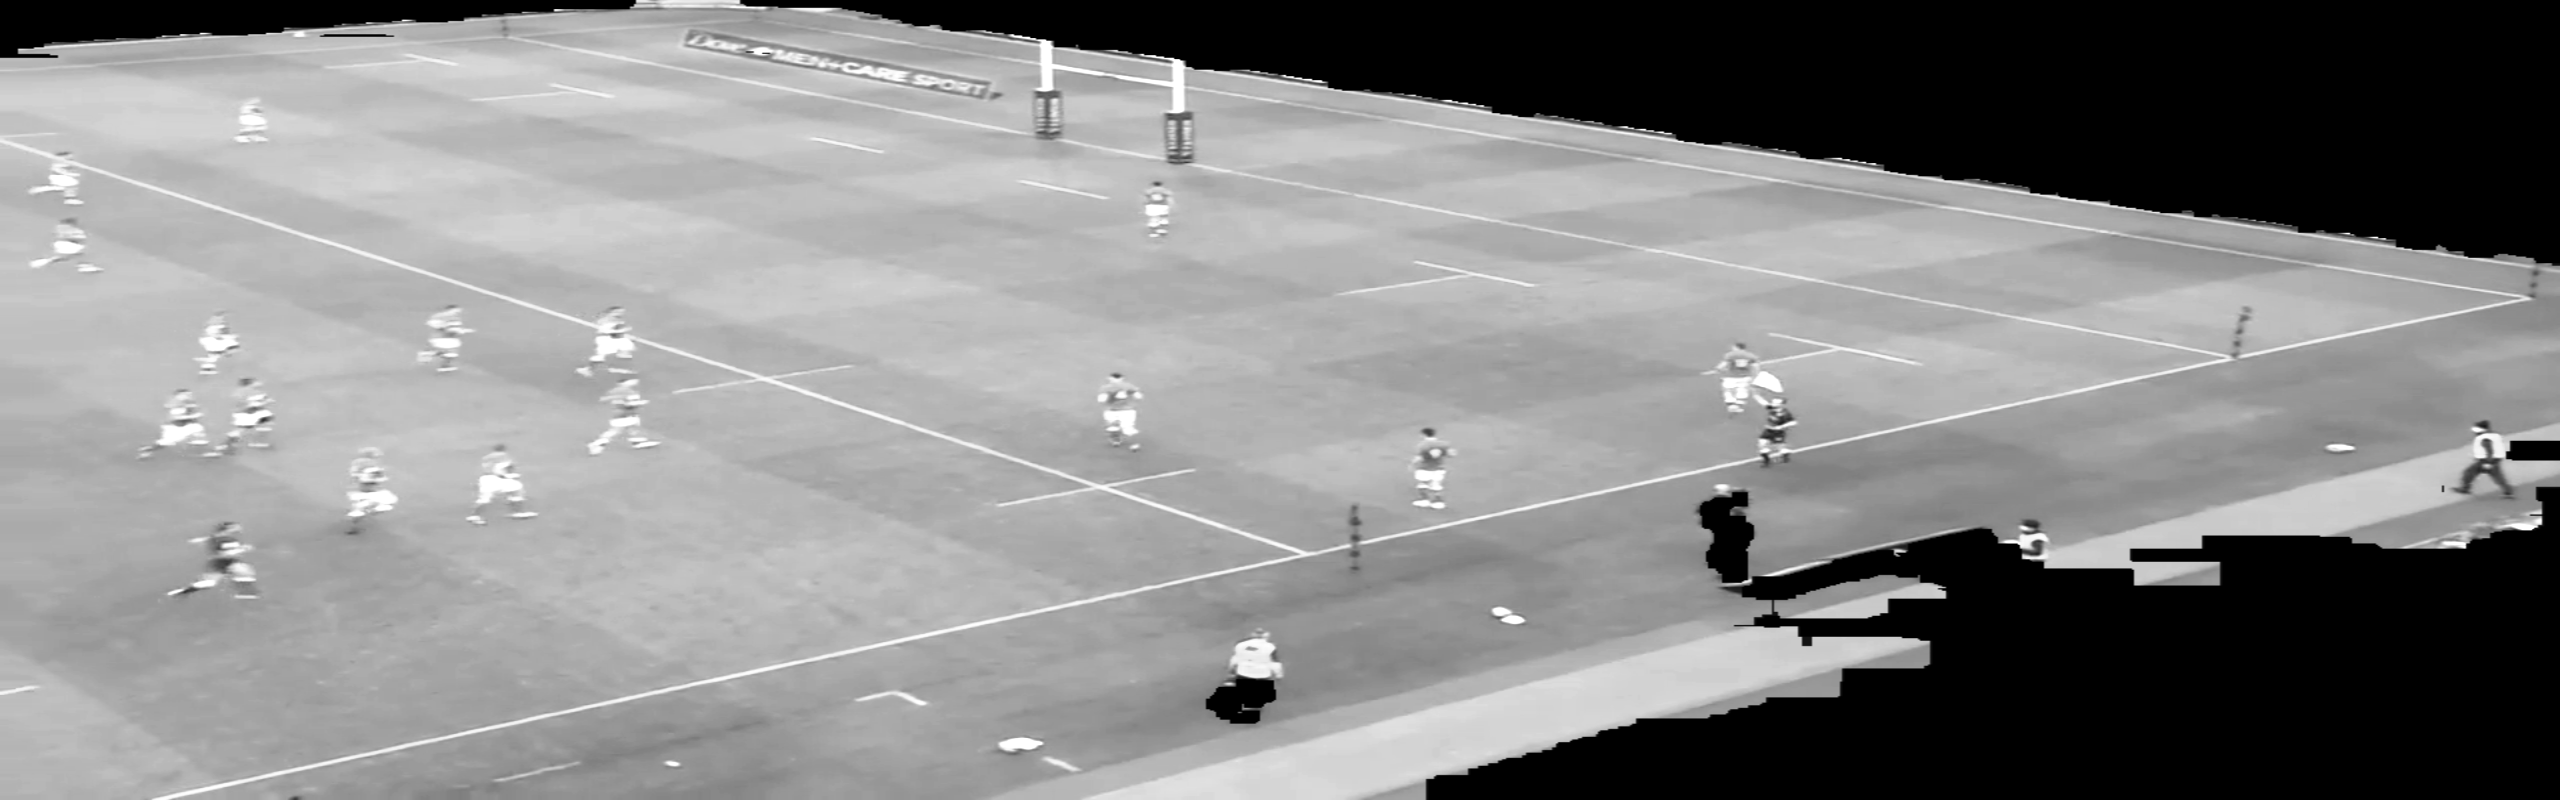

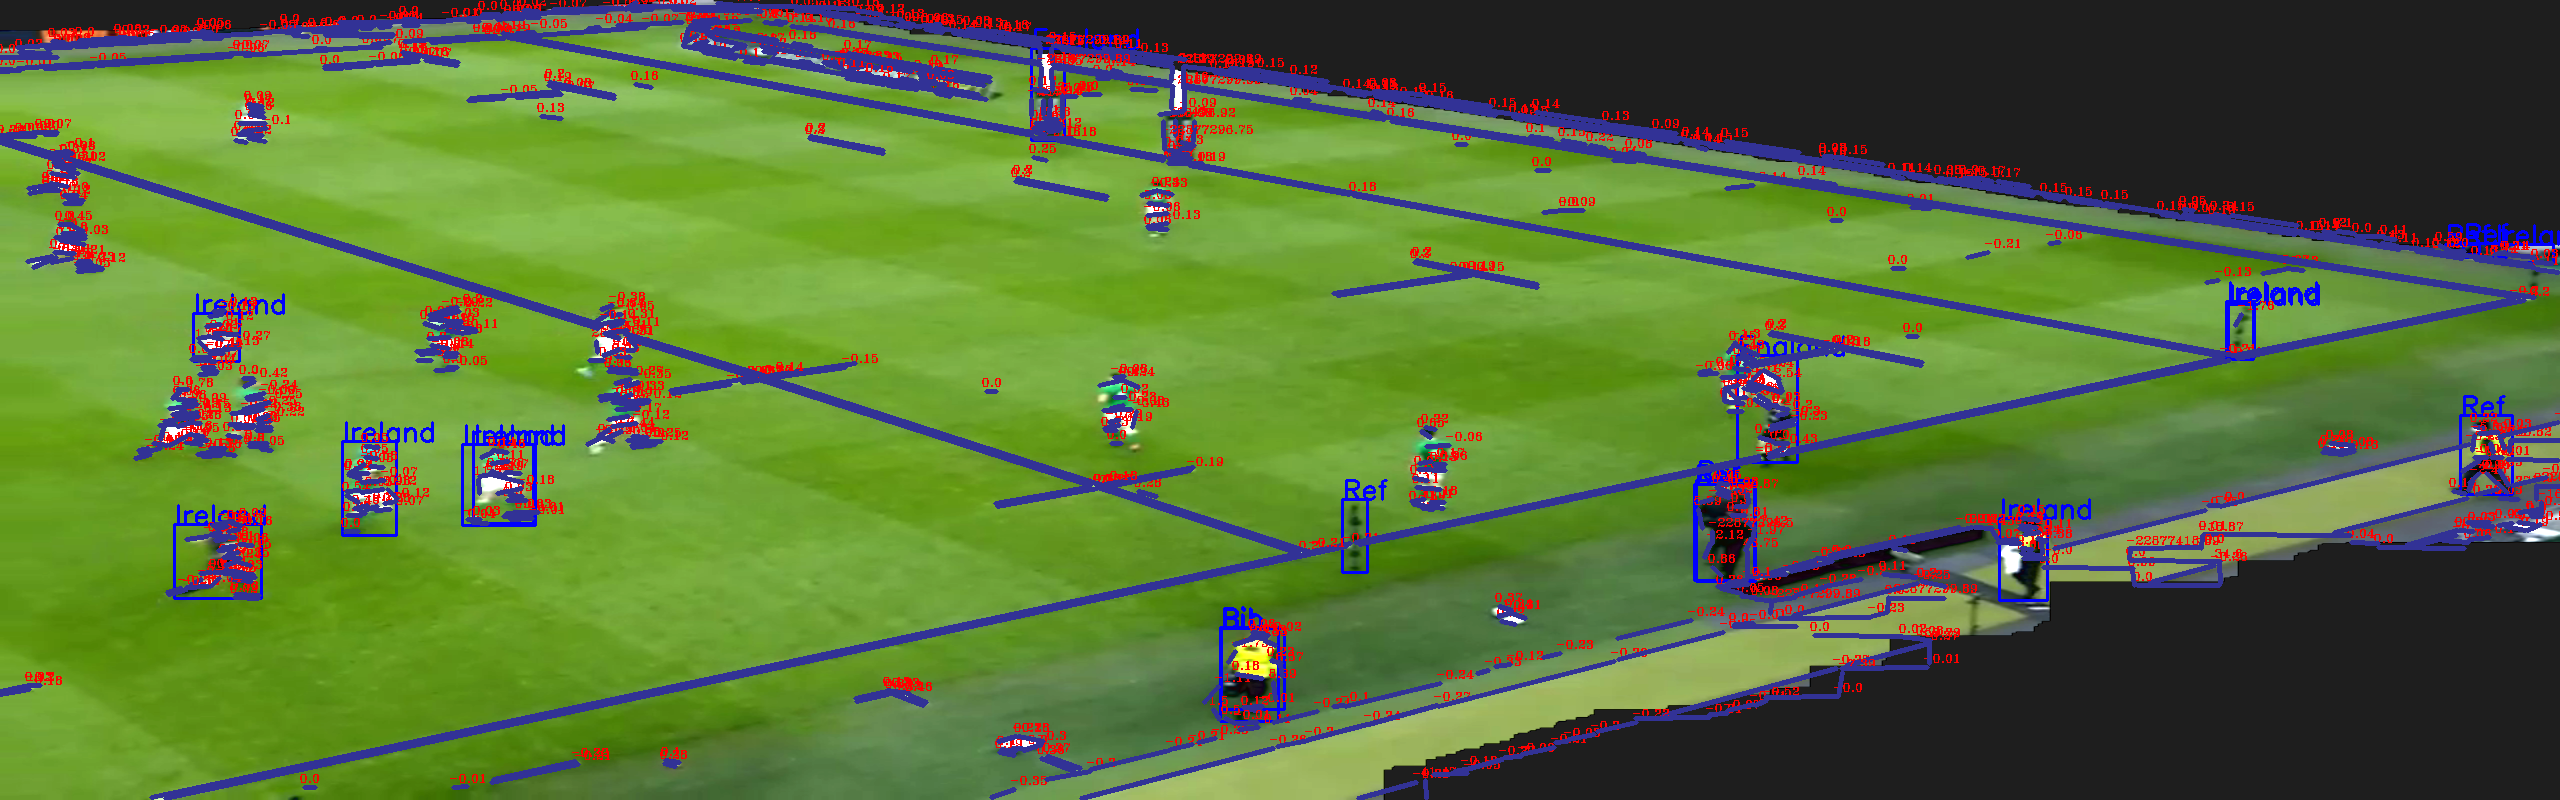

twenty2orTryLine


  return _methods._mean(a, axis=axis, dtype=dtype,

  ret = ret.dtype.type(ret / rcount)



tryLn22OrSideLn
tryLineOrEndLine


  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,

  arrmean = um.true_divide(arrmean, div, out=arrmean,

  ret = ret.dtype.type(ret / rcount)



lengthPrioritizeLines(['trylineL','trylineR'])
removeBadCrossPitchLines


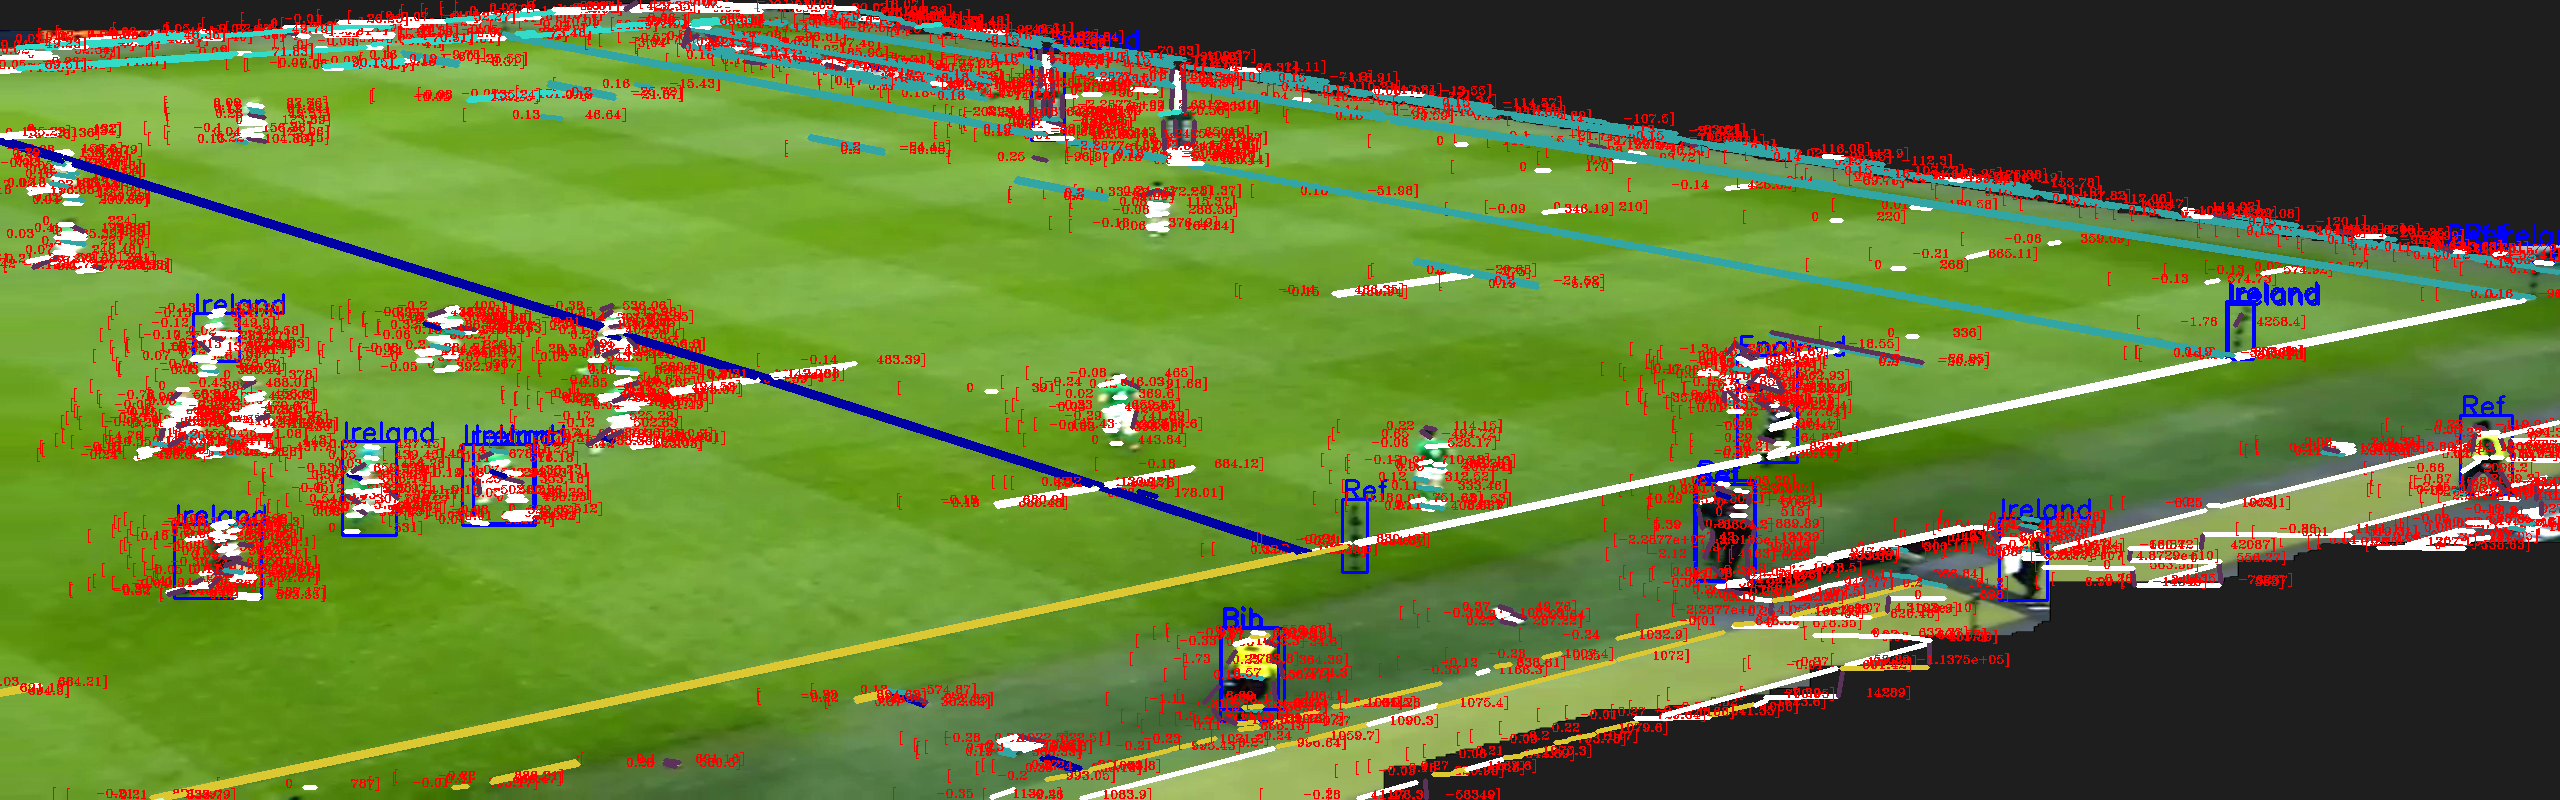

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'line'
> Overload resolution failed:
>  - Can't parse 'pt2'. Sequence item with index 1 has a wrong type
>  - Can't parse 'pt2'. Sequence item with index 1 has a wrong type


In [227]:
filePath = "/content/drive/My Drive/UL_Masters/rugby/"
try:
  vid_cap
except:
  vid_cap = cv2.VideoCapture(filePath+"outputs/playTrim/trim.mp4")
skipFrames = []#np.arange(0,59)#[30,45,60]#[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# skipFrames = np.arange(0,38)
pitchDetector = RugbyFieldRegistration()
with warnings.catch_warnings():
  VideoWriter().run(cap=vid_cap, save_path=filePath+"outputs/playTrim/projection.mp4", VideoProcessorClass=pitchDetector, skipFrames=skipFrames, output_fps=2)

In [ ]:
# filePath = "/content/drive/My Drive/UL_Masters/rugby/"
# vid_cap = cv2.VideoCapture(filePath+"outputs/playTrim/trim2.mp4")
# skipFrames = []#np.arange(0,59)#[30,45,60]#[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# # skipFrames = np.arange(0,38)
# pitchDetector = RugbyFieldRegistration()
# with warnings.catch_warnings():
#   VideoWriter().run(cap=vid_cap, save_path=filePath+"outputs/playTrim/projection2.mp4", VideoProcessorClass=pitchDetector, skipFrames=skipFrames, output_fps=2)